In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc, roc_auc_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import seaborn as sns

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\New Airtel Score")

# Read Data

In [3]:
# df = pd.read_parquet('supervised_airtel_20210319')
# df.to_csv("upload_airtel_scores.csv", index = False)

In [4]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\export_v1.csv")
df['TIME_DECISION_DATE'] = pd.to_datetime(df['TIME_DECISION_DATE'], format = '%d-%m-%y')

In [5]:
df.dropna(subset = ['RISK_SCORE'], inplace = True)

# Exi Clients

In [6]:
df= df[df.CLIENT_EXI_3M == 'Y']

# Define Key Functions

In [7]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [8]:
def lift_and_gain_df(data=None,target=None, prob=None, bucket = 10):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), bucket)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped.agg(['min'])[prob].iloc[:,0]
    liftstable['max_prob'] = grouped.agg(['max'])[prob].iloc[:,0]
    liftstable['total']   = grouped.agg(['count'])[target].iloc[:,0]
    liftstable['bads']   = round(grouped.agg(['sum'])[target].iloc[:,0])
    liftstable['goods'] = round(grouped.agg(['sum'])['target0'].iloc[:,0])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

In [9]:
def logit(x): 
    return np.log(x/(1-x))

# Combine GM Old Airtel

In [10]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,DECISION_MONTH,PRODUCT_GROUP,CLIENT_EXI_3M,NTC_FLAG,RISK_SCORE,DECISION_OVERALL,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,FLAG_1PCT_PHANTOM,RISK_AGRF10,RISK_AGRF30,RISK_AGRF60,RISK_AGRF90,AIRTEL_SCORE,REJECT_TYPE,NEW_AIRTEL_SCORE
10817,327384676,2020-11-25,01-11-20,CD,Y,Others,0.046409,Approved,0,0,0,0,0,1,1,1,1,0.094464,SCORE_REJECT,0.063293
10823,327384742,2020-11-25,01-11-20,CD,Y,Others,0.023582,Approved,0,0,0,0,0,1,1,1,1,0.046950,SCORE_REJECT,0.030533
10826,327385104,2020-11-25,01-11-20,CD,Y,Others,0.036627,Approved,0,0,0,0,0,1,1,1,1,0.090897,SCORE_REJECT,0.113220
10827,327384780,2020-11-25,01-11-20,CD,Y,Others,0.032935,Approved,0,0,0,0,0,1,1,1,1,0.098163,SCORE_REJECT,0.051340
10828,327384794,2020-11-25,01-11-20,CD,Y,Others,0.019581,Approved,0,0,0,0,0,1,1,1,1,0.062797,SCORE_REJECT,0.026566


In [11]:
df.DECISION_MONTH.value_counts()

01-01-21    23339
01-12-20    21023
01-11-20     3398
01-02-21     1401
Name: DECISION_MONTH, dtype: int64

In [12]:
train_start = pd.datetime(2020,6,1)
train_end = pd.datetime(2020,12,31)
test_start = pd.datetime(2021,1,1)
test_end = pd.datetime(2021,1,31)
hcc_score='RISK_SCORE'
target = 'RISK_FPD30'
observable = 'RISK_AGRF30'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The

In [13]:
df["RISK_SCORE_LIN"] = logit(df["RISK_SCORE"])
df["AIRTEL_SCORE_LIN"] = logit(df["AIRTEL_SCORE"])

x_columns=['RISK_SCORE_LIN','AIRTEL_SCORE_LIN']
y_column = target
seed = 2

df.dropna(subset = [hcc_score], inplace = True)

X_train_all = df[(df.TIME_DECISION_DATE>=train_start) & (df.TIME_DECISION_DATE<=train_end)]
y_train_all = df[(df.TIME_DECISION_DATE>=train_start) & (df.TIME_DECISION_DATE<=train_end)][y_column]

X_test = df[(df.TIME_DECISION_DATE>=test_start) & (df.TIME_DECISION_DATE<=test_end)]
y_test = df[(df.TIME_DECISION_DATE>=test_start) & (df.TIME_DECISION_DATE<=test_end)][y_column]

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size = 0.7, random_state = seed)

##event rate
print("Event rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("Train set shape:",X_train.shape)
print("Event rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("Test set shape:",X_test.shape)
print("Event rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("validation set shape:",X_valid.shape)
print("Train GINI",  roc_auc_score(y_train, X_train[hcc_score])*2 -1)
print("Test GINI",  roc_auc_score(y_test, X_test[hcc_score])*2 -1)
print("validation GINI",  roc_auc_score(y_valid, X_valid[hcc_score])*2 -1)

Event rate in train set : 0.41%
Train set shape: (7326, 22)
Event rate in test set : 0.52%
Test set shape: (23339, 22)
Event rate in validation set : 0.46%
validation set shape: (17095, 22)
Train GINI 0.1582419590643276
Test GINI 0.44969242302032697
validation GINI 0.35430030000165735


## L1 Penalty Hyper Parameter Optimization

In [14]:
param_grid = {'C':np.exp(np.arange(-3,4,0.01))}

In [15]:
kfolds = StratifiedKFold(3, random_state=1, shuffle = True)
comb=LogisticRegression(penalty = 'l1', solver = 'liblinear')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 30,
    cv=kfolds.split(X_train[x_columns],y_train), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [16]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train[x_columns], y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 

Randomized search..
Randomized search time: 1.8969454765319824


{'C': 0.11191674861732694}


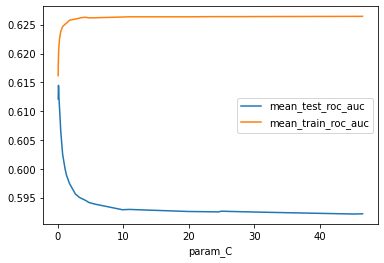

In [17]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')
tmp1.plot(x="param_C")
print(params)

## Logistic With optimized Hyperparameters 

In [18]:
from sklearn.linear_model import LogisticRegression

bst = LogisticRegression(penalty = 'l1', C=params['C'], solver='liblinear')

bst.fit(X_train[x_columns], y_train)

ypred_train = bst.predict_proba(X_train[x_columns])[:, 1]
ypred_valid = bst.predict_proba(X_valid[x_columns])[:, 1]
ypred_test = bst.predict_proba(X_test[x_columns])[:, 1]

print("Train GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_train, ypred_train)-1))
print("Valid GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_valid, ypred_valid)-1))
print("Test GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_test, ypred_test)-1))

print("Train GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_train, X_train[hcc_score])-1))
print("Valid GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_valid, X_valid[hcc_score])-1))
print("Test GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_test, X_test[hcc_score])-1))


Train GINI(COMBINED_SCORE) 0.238
Valid GINI(COMBINED_SCORE) 0.349
Test GINI(COMBINED_SCORE) 0.444
Train GINI(RISK_SCORE) 0.158
Valid GINI(RISK_SCORE) 0.354
Test GINI(RISK_SCORE) 0.450


In [19]:
pd.DataFrame({"column":x_columns,"coeffecient":bst.coef_[0]})

,column,coeffecient
0,RISK_SCORE_LIN,0.825358
1,AIRTEL_SCORE_LIN,1.287445


In [20]:
bst.intercept_

array([-0.32164313])

In [21]:
df["COMBINED_SCORE_OLD_AIR"] =  bst.predict_proba(df[x_columns])[:, 1]

# Combine GM New Airtel

In [22]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,DECISION_MONTH,PRODUCT_GROUP,CLIENT_EXI_3M,NTC_FLAG,RISK_SCORE,DECISION_OVERALL,RISK_FPD10,RISK_FPD30,...,RISK_AGRF10,RISK_AGRF30,RISK_AGRF60,RISK_AGRF90,AIRTEL_SCORE,REJECT_TYPE,NEW_AIRTEL_SCORE,RISK_SCORE_LIN,AIRTEL_SCORE_LIN,COMBINED_SCORE_OLD_AIR
10817,327384676,2020-11-25,01-11-20,CD,Y,Others,0.046409,Approved,0,0,...,1,1,1,1,0.094464,SCORE_REJECT,0.063293,-3.022735,-2.260311,0.003248
10823,327384742,2020-11-25,01-11-20,CD,Y,Others,0.023582,Approved,0,0,...,1,1,1,1,0.046950,SCORE_REJECT,0.030533,-3.723396,-3.010577,0.000695
10826,327385104,2020-11-25,01-11-20,CD,Y,Others,0.036627,Approved,0,0,...,1,1,1,1,0.090897,SCORE_REJECT,0.113220,-3.269668,-2.302730,0.002510
10827,327384780,2020-11-25,01-11-20,CD,Y,Others,0.032935,Approved,0,0,...,1,1,1,1,0.098163,SCORE_REJECT,0.051340,-3.379720,-2.217803,0.002557
10828,327384794,2020-11-25,01-11-20,CD,Y,Others,0.019581,Approved,0,0,...,1,1,1,1,0.062797,SCORE_REJECT,0.026566,-3.913405,-2.702988,0.000883


In [23]:
df.DECISION_MONTH.value_counts()

01-01-21    23339
01-12-20    21023
01-11-20     3398
01-02-21     1401
Name: DECISION_MONTH, dtype: int64

In [24]:
train_start = pd.datetime(2020,6,1)
train_end = pd.datetime(2020,12,31)
test_start = pd.datetime(2021,1,1)
test_end = pd.datetime(2021,1,31)
hcc_score='RISK_SCORE'
target = 'RISK_FPD30'
observable = 'RISK_AGRF30'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The

In [25]:
df["RISK_SCORE_LIN"] = logit(df["RISK_SCORE"])
df["NEW_AIRTEL_SCORE_LIN"] = logit(df["NEW_AIRTEL_SCORE"])

x_columns=['RISK_SCORE_LIN','NEW_AIRTEL_SCORE_LIN']
y_column = target
seed = 2

df.dropna(subset = [hcc_score], inplace = True)

X_train_all = df[(df.TIME_DECISION_DATE>=train_start) & (df.TIME_DECISION_DATE<=train_end)]
y_train_all = df[(df.TIME_DECISION_DATE>=train_start) & (df.TIME_DECISION_DATE<=train_end)][y_column]

X_test = df[(df.TIME_DECISION_DATE>=test_start) & (df.TIME_DECISION_DATE<=test_end)]
y_test = df[(df.TIME_DECISION_DATE>=test_start) & (df.TIME_DECISION_DATE<=test_end)][y_column]

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size = 0.7, random_state = seed)

##event rate
print("Event rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("Train set shape:",X_train.shape)
print("Event rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("Test set shape:",X_test.shape)
print("Event rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("validation set shape:",X_valid.shape)
print("Train GINI",  roc_auc_score(y_train, X_train[hcc_score])*2 -1)
print("Test GINI",  roc_auc_score(y_test, X_test[hcc_score])*2 -1)
print("validation GINI",  roc_auc_score(y_valid, X_valid[hcc_score])*2 -1)

Event rate in train set : 0.41%
Train set shape: (7326, 24)
Event rate in test set : 0.52%
Test set shape: (23339, 24)
Event rate in validation set : 0.46%
validation set shape: (17095, 24)
Train GINI 0.1582419590643276
Test GINI 0.44969242302032697
validation GINI 0.35430030000165735


## L1 Penalty Hyper Parameter Optimization

In [26]:
param_grid = {'C':np.exp(np.arange(-3,4,0.01))}

In [27]:
kfolds = StratifiedKFold(3, random_state=1, shuffle = True)
comb=LogisticRegression(penalty = 'l1', solver = 'liblinear')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 30,
    cv=kfolds.split(X_train[x_columns],y_train), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [28]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train[x_columns], y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 

Randomized search..
Randomized search time: 2.0083842277526855


{'C': 0.06266200474215285}


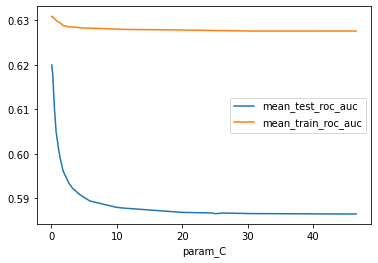

In [29]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')
tmp1.plot(x="param_C")
print(params)

## Logistic With optimized Hyperparameters 

In [30]:
from sklearn.linear_model import LogisticRegression

bst = LogisticRegression(penalty = 'l1', C=params['C'], solver='liblinear')

bst.fit(X_train[x_columns], y_train)

ypred_train = bst.predict_proba(X_train[x_columns])[:, 1]
ypred_valid = bst.predict_proba(X_valid[x_columns])[:, 1]
ypred_test = bst.predict_proba(X_test[x_columns])[:, 1]

print("Train GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_train, ypred_train)-1))
print("Valid GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_valid, ypred_valid)-1))
print("Test GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_test, ypred_test)-1))

print("Train GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_train, X_train[hcc_score])-1))
print("Valid GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_valid, X_valid[hcc_score])-1))
print("Test GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_test, X_test[hcc_score])-1))


Train GINI(COMBINED_SCORE) 0.257
Valid GINI(COMBINED_SCORE) 0.428
Test GINI(COMBINED_SCORE) 0.538
Train GINI(RISK_SCORE) 0.158
Valid GINI(RISK_SCORE) 0.354
Test GINI(RISK_SCORE) 0.450


In [31]:
pd.DataFrame({"column":x_columns,"coeffecient":bst.coef_[0]})

,column,coeffecient
0,RISK_SCORE_LIN,0.625963
1,NEW_AIRTEL_SCORE_LIN,1.133905


In [32]:
bst.intercept_

array([0.])

In [33]:
df["COMBINED_SCORE_NEW_AIR"] =  bst.predict_proba(df[x_columns])[:, 1]

In [34]:
df.columns

Index(['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'DECISION_MONTH',
       'PRODUCT_GROUP', 'CLIENT_EXI_3M', 'NTC_FLAG', 'RISK_SCORE',
       'DECISION_OVERALL', 'RISK_FPD10', 'RISK_FPD30', 'RISK_FSPD30',
       'RISK_FSTPD30', 'FLAG_1PCT_PHANTOM', 'RISK_AGRF10', 'RISK_AGRF30',
       'RISK_AGRF60', 'RISK_AGRF90', 'AIRTEL_SCORE', 'REJECT_TYPE',
       'NEW_AIRTEL_SCORE', 'RISK_SCORE_LIN', 'AIRTEL_SCORE_LIN',
       'COMBINED_SCORE_OLD_AIR', 'NEW_AIRTEL_SCORE_LIN',
       'COMBINED_SCORE_NEW_AIR'],
      dtype='object')

### Gini Chart

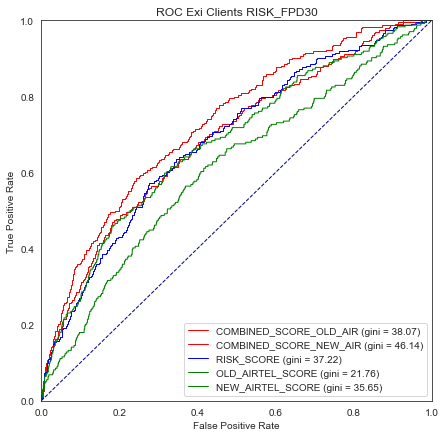

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(df[target],df["COMBINED_SCORE_OLD_AIR"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_OLD_AIR (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[target],df["COMBINED_SCORE_NEW_AIR"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_NEW_AIR (gini = %0.2f)' % ((2*roc_auc-1)*100))


fpr, tpr, thresholds = roc_curve(df[target],df["RISK_SCORE"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label="RISK_SCORE"+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[target],df["AIRTEL_SCORE"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='OLD_AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[target],df["NEW_AIRTEL_SCORE"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='NEW_AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Exi Clients ' + target)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [40]:
df["DECISION_MONTH"].unique()

array(['01-11-20', '01-12-20', '01-01-21', '01-02-21'], dtype=object)

In [41]:
gini_dic = {}
for x in ['01-11-20', '01-12-20', '01-01-21','01-02-21']:
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "AIRTEL_SCORE" not in gini_dic: 
            gini_dic["AIRTEL_SCORE"] = []
        if "NEW_AIRTEL_SCORE" not in gini_dic: 
            gini_dic["NEW_AIRTEL_SCORE"] = []
        if "COMBINED_SCORE_NEW_AIR" not in gini_dic: 
            gini_dic["COMBINED_SCORE_NEW_AIR"] = []
        if "COMBINED_SCORE_OLD_AIR" not in gini_dic: 
            gini_dic["COMBINED_SCORE_OLD_AIR"] = []
        if "RISK_SCORE" not in gini_dic: 
            gini_dic["RISK_SCORE"] = []
        
        gini_dic["AIRTEL_SCORE"].append((2*roc_auc_score(df[df["DECISION_MONTH"]==x][target],df[df["DECISION_MONTH"]==x]["AIRTEL_SCORE"])-1)*100)
        gini_dic["NEW_AIRTEL_SCORE"].append((2*roc_auc_score(df[df["DECISION_MONTH"]==x][target],df[df["DECISION_MONTH"]==x]["NEW_AIRTEL_SCORE"])-1)*100)
        gini_dic["COMBINED_SCORE_NEW_AIR"].append((2*roc_auc_score(df[df["DECISION_MONTH"]==x][target],df[df["DECISION_MONTH"]==x]["COMBINED_SCORE_NEW_AIR"])-1)*100)
        gini_dic["COMBINED_SCORE_OLD_AIR"].append((2*roc_auc_score(df[df["DECISION_MONTH"]==x][target],df[df["DECISION_MONTH"]==x]["COMBINED_SCORE_OLD_AIR"])-1)*100)
        gini_dic["RISK_SCORE"].append((2*roc_auc_score(df[df["DECISION_MONTH"]==x][target],df[df["DECISION_MONTH"]==x]["RISK_SCORE"])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)
gini_df = gini_df.sort_values(by = 'index')

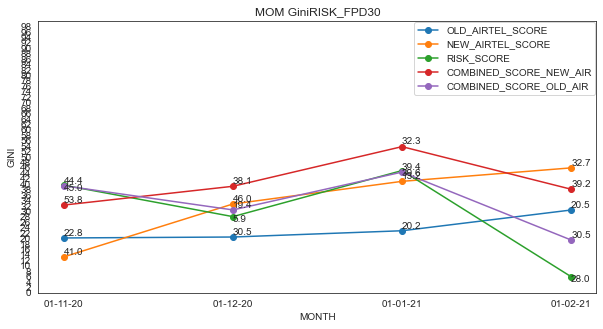

In [42]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["AIRTEL_SCORE"], marker='o', scaley = False, label = "OLD_AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["NEW_AIRTEL_SCORE"], marker='o', scaley = False, label = "NEW_AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["RISK_SCORE"], marker='o', scaley = False, label = "RISK_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE_NEW_AIR"], marker='o', scaley = False, label= "COMBINED_SCORE_NEW_AIR")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE_OLD_AIR"], marker='o', scaley = False, label= "COMBINED_SCORE_OLD_AIR")


for i, txt in enumerate(gini_df["AIRTEL_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["AIRTEL_SCORE"][i]+0.9))
for i, txt in enumerate(gini_df["NEW_AIRTEL_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_AIRTEL_SCORE"][i]+0.9))
for i, txt in enumerate(gini_df["RISK_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["RISK_SCORE"][i]-1.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE_OLD_AIR"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE_OLD_AIR"][i]+0.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE_NEW_AIR"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE_NEW_AIR"][i]+0.9))

plt.legend(loc='upper right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini" + target)
plt.show()

## Lifts and Gains Chart

In [43]:
#cum%_bads is gain_score
combined_score_new_air_lift = lift_and_gain_df(data=df,target=target, prob='COMBINED_SCORE_NEW_AIR', bucket=10)
combined_score_old_air_lift = lift_and_gain_df(data=df,target=target, prob='COMBINED_SCORE_OLD_AIR', bucket=10)
risk_score_lift = lift_and_gain_df(data=df,target=target, prob="RISK_SCORE", bucket=10)
old_airtel_score_lift = lift_and_gain_df(data=df,target=target, prob="AIRTEL_SCORE", bucket=10)
new_airtel_score_lift = lift_and_gain_df(data=df,target=target, prob="NEW_AIRTEL_SCORE", bucket=10)

### Cumulative Lift Chart 

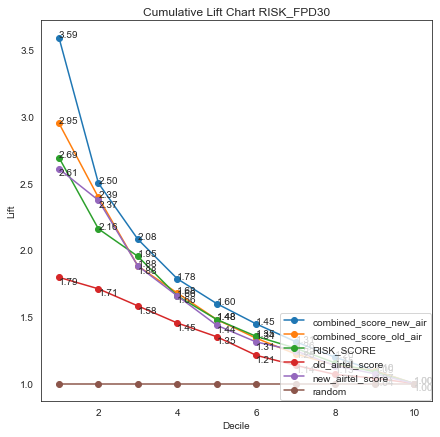

In [44]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


    
ax1.plot(combined_score_new_air_lift.index,combined_score_new_air_lift["cum_lift"], label = "combined_score_new_air", marker='o')
for i, txt in enumerate(combined_score_new_air_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_new_air_lift.index[i], combined_score_new_air_lift["cum_lift"][i+1]))

ax1.plot(combined_score_old_air_lift.index,combined_score_old_air_lift["cum_lift"], label = "combined_score_old_air", marker='o')
for i, txt in enumerate(combined_score_old_air_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_old_air_lift.index[i], combined_score_old_air_lift["cum_lift"][i+1]))

    
ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = "RISK_SCORE", marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(old_airtel_score_lift.index,old_airtel_score_lift["cum_lift"], label = "old_airtel_score", marker='o')
for i, txt in enumerate(old_airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (old_airtel_score_lift.index[i], old_airtel_score_lift["cum_lift"][i+1]-0.05))

ax1.plot(new_airtel_score_lift.index,new_airtel_score_lift["cum_lift"], label = "new_airtel_score", marker='o')
for i, txt in enumerate(new_airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (new_airtel_score_lift.index[i], new_airtel_score_lift["cum_lift"][i+1]-0.05))


ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+target)
plt.show()    


# Population Shift

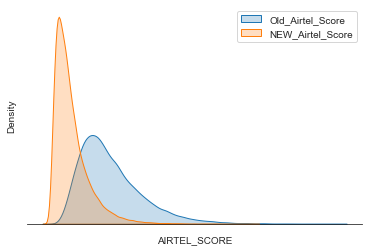

In [45]:
sns.set_style("white")
plot = sns.kdeplot(df["AIRTEL_SCORE"], shade=True, label = 'Old_Airtel_Score' )
plot = sns.kdeplot(df["NEW_AIRTEL_SCORE"], shade=True, label = 'NEW_Airtel_Score' )
plot.set(yticklabels=[], xticklabels = [])
sns.despine(left=True)
plt.legend()
plt.show()


# Correlation Chart

<AxesSubplot:>

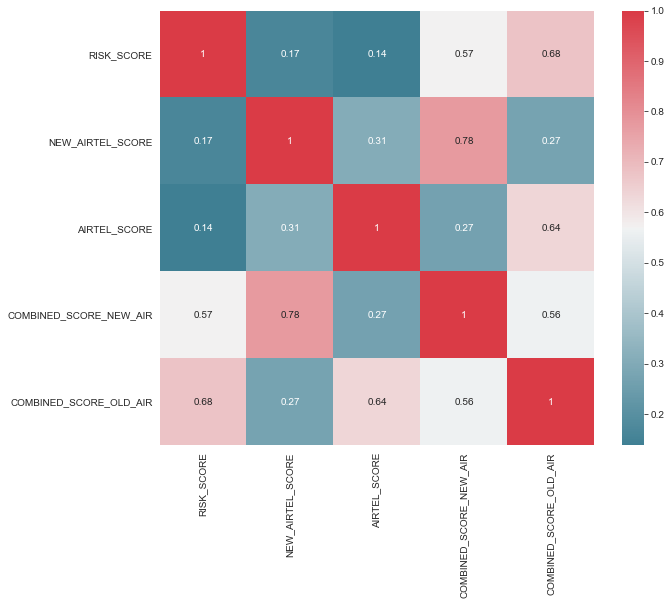

In [46]:
import seaborn as sns

columns = ["RISK_SCORE","NEW_AIRTEL_SCORE","AIRTEL_SCORE", "COMBINED_SCORE_NEW_AIR","COMBINED_SCORE_OLD_AIR"]

f, ax = plt.subplots(figsize=(10, 8))
corr = df[columns].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)